In [40]:
import numpy as np
import pysindy as ps

from scipy.integrate import solve_ivp
from pysindy.utils import linear_damped_SHO, cubic_damped_SHO, van_der_pol

import matplotlib.pyplot as plt

from numpy import genfromtxt

import deepSI
from deepSI import System_data

import torch
from torch import nn
from torch.nn import functional as F

import csv
import os

In [41]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# training data
dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(van_der_pol, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

# training data
t_test = np.arange(0, 25, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = [0.1, 0.5]
x_test = solve_ivp(van_der_pol, t_test_span,
                    x0_test, t_eval=t_test, **integrator_keywords).y.T

In [42]:
def normalize(y):
  y_mu = np.mean(y)
  y_std = np.std(y)
  y_norm = (y-y_mu)/y_std

  return y_norm, y_std, y_mu

In [43]:
# generate function set
x_train, x_std, x_mu = normalize(x_train)

degree = 2

train_x = x_train[:-1,:]
Theta = torch.as_tensor(np.array(ps.PolynomialLibrary(degree=degree).fit(train_x).transform(train_x))).to(torch.float32)

target_x = torch.as_tensor(x_train[1:,:]).to(torch.float32)

test_x = x_test[:-1,:]
Theta_test = torch.as_tensor(np.array(ps.PolynomialLibrary(degree=degree).fit(test_x).transform(test_x))).to(torch.float32)
target_x_test = torch.as_tensor(x_test[1:,:]).to(torch.float32)

In [44]:
import torch
from torch import nn
from torch.nn import functional as F

class MLP(torch.nn.Module):
    def __init__(self, n_in, n_out, threshold=0):
        super(MLP, self).__init__()
        
        self.layer = nn.Linear(n_in, n_out) if threshold==0 else PruningLinear(n_in, n_out, threshold)
        # self.layer = 

    def forward(self, x):
        out = self.layer(x)
        return out
    
class PruningLinear(torch.nn.Linear):
    def __init__(self, in_features, out_features, threshold, **kwargs):
        super(PruningLinear, self).__init__(in_features, out_features, **kwargs)
        self.threshold = threshold

    def forward(self, input):
        weight = self.weight.clone()
        weight[torch.abs(weight) < self.threshold] = 0
        self.weight = nn.Parameter(weight)
        return F.linear(input, self.weight, self.bias)
    

In [45]:
n_in = Theta.shape[-1]
n_out = target_x.shape[-1]

model = MLP(n_in, n_out)

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [47]:
def SINDyLoss(X, Theta, Xi, l):
    # reg_loss = torch.sum(1/(X.shape[0]) * torch.sqrt((X-torch.matmul(Theta,torch.transpose(Xi,0,1)))**2)**2)
    reg_loss = 1/X.shape[0] *torch.sum(torch.abs(X-torch.matmul(Theta,torch.transpose(Xi,0,1)))**2)
    l1_loss = l**2*torch.sum(torch.abs(Xi))
    return reg_loss, l1_loss

def SINDyLoss2(X_pred, X_true, Theta, Xi, l):
    # reg_loss = torch.sum(1/(X.shape[0]) * torch.sqrt((X-torch.matmul(Theta,torch.transpose(Xi,0,1)))**2)**2)
    reg_loss = 1/X_true.shape[0] *torch.sum(torch.abs(X_true-torch.matmul(Theta,torch.transpose(Xi,0,1)))**2)
    pred_loss = 1/X_true.shape[0] *torch.sum(torch.abs(X_true-X_pred)**2)
    l1_loss = l**2*torch.sum(torch.abs(Xi))
    return reg_loss, pred_loss, l1_loss

In [48]:
epochs = 25000

lambda_1 = 0

losses = []

for epo in range(epochs):
    optimizer.zero_grad()
    output = model(Theta)

    # loss
    Xi = [*model.parameters()][0]
    reg, pred, l1 = SINDyLoss2(output, target_x, Theta, Xi, lambda_1)
    loss = reg+l1+pred
    losses.append(loss.detach().numpy())

    loss.backward()

    optimizer.step()
    if (epo%(epochs//10)==0 or epo==epochs-1) and epo != 0:
        epo_p = epo if epo != epochs-1 else epo+1
        print("Epoch {} train loss: {:.5f}".format(epo_p, loss))
        print("reg loss {:.5f}, pred loss {:.5f}, l1 loss: {:.5f}".format(reg, pred, l1))

Epoch 2500 train loss: 3.31983
reg loss 1.66393, pred loss 1.65589, l1 loss: 0.00000
Epoch 5000 train loss: 1.89550
reg loss 0.94847, pred loss 0.94703, l1 loss: 0.00000
Epoch 7500 train loss: 1.00473
reg loss 0.50246, pred loss 0.50227, l1 loss: 0.00000
Epoch 10000 train loss: 0.45886
reg loss 0.22946, pred loss 0.22941, l1 loss: 0.00000
Epoch 12500 train loss: 0.15329
reg loss 0.07665, pred loss 0.07665, l1 loss: 0.00000
Epoch 15000 train loss: 0.02401
reg loss 0.01201, pred loss 0.01200, l1 loss: 0.00000
Epoch 17500 train loss: 0.00050
reg loss 0.00025, pred loss 0.00025, l1 loss: 0.00000
Epoch 20000 train loss: 0.00005
reg loss 0.00002, pred loss 0.00002, l1 loss: 0.00000
Epoch 22500 train loss: 0.00005
reg loss 0.00002, pred loss 0.00002, l1 loss: 0.00000
Epoch 25000 train loss: 0.00005
reg loss 0.00002, pred loss 0.00002, l1 loss: 0.00000


In [49]:
test_pred = model(Theta_test).detach().numpy()
test_true = target_x_test.detach().numpy()
np.sum(np.abs(test_pred-test_true), axis=0)/test_pred.shape[0]

array([0.00011045, 0.0049091 ], dtype=float32)

In [55]:
threshold = 0.002
params = [x.detach().numpy() for x in model.parameters()][0]
NN_p = params[np.abs(params) > threshold]

In [51]:
poly_order = 3
threshold = 0.002

s_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    discrete_time=True
)
s_model.fit(x_train, t=dt)
s_model.print(precision=5)


# plt.plot(x_train[0:2500])
# plt.plot(x_train[0:2500,:]-model.simulate(x_train[0],t=2500))

(x0)[k+1] = 0.99995 x0[k] + 0.01000 x1[k]
(x1)[k+1] = -0.01001 x0[k] + 1.00493 x1[k] + -0.01006 x0[k]^2 x1[k]


In [52]:
coeff = s_model.coefficients()
S_p = coeff[coeff != 0]

In [56]:
NN_p, S_p

(array([ 0.9999509 ,  0.01001487,  0.00220353, -0.00981096,  1.0000433 ],
       dtype=float32),
 array([ 0.99995258,  0.0099986 , -0.0100088 ,  1.00493408, -0.01005527]))

(-1.0, 30.0)

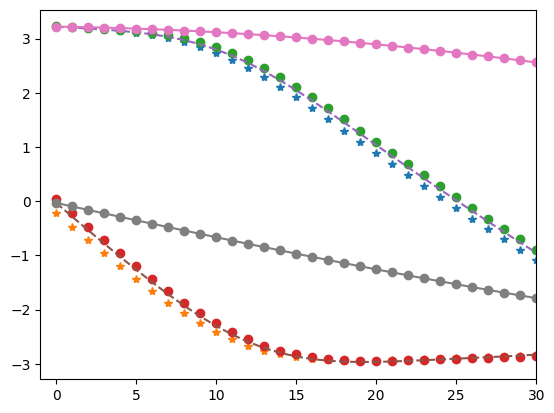

In [ ]:
x_1 = x_train[:-1]
x_true = x_train[1:]
x1_c = [0.99878565,  0.01999398]#
x2_c = [-0.0199617 ,  0.99878345]#
x0 = x_1[0]

x_pred = []
x_sim = [x0]

for idx, x in enumerate(x_1):
  x_pred.append(np.array([x1_c[0]*x[0]+x1_c[1]*x[1], x2_c[0]*x[0]+x2_c[1]*x[1]]))
  x_sim.append(np.array([x1_c[0]*x_sim[idx][0]+x1_c[1]*x_sim[idx][1], x2_c[0]*x_sim[idx][0]+x2_c[1]*x_sim[idx][1]]))

x_sim.pop(0)


plt.plot(range(0,x_true.shape[0]), x_true,"*")
plt.plot(range(0,x_1.shape[0]),x_1,'o')
plt.plot(range(0,len(x_pred)),x_pred,'--')
plt.plot(range(0,len(x_sim)),x_sim,'-o')
plt.xlim([-1, 30])